In this notebook, we will analyze a benchmark simulation of alanine dipeptide. We will use geometric clustering to build a fine-grained Markov State Model, then use kinetic information coarse-grain that model. We'll compare metastability optimization with PCCA+ and spectral co/bi-clustering.

In [1]:
# load trajectory data
from msmbuilder.example_datasets import AlanineDipeptide
ala = AlanineDipeptide().get().trajectories

In [2]:
%%time

# cluster by min-RMSD
from msmbuilder.cluster import MiniBatchKMedoids
kmeds = MiniBatchKMedoids(200,metric='rmsd',batch_size=200)
kmeds.fit(ala)

CPU times: user 59.3 s, sys: 210 ms, total: 59.5 s
Wall time: 59.9 s


In [3]:
# assign to discrete states
dtrajs = kmeds.transform(ala)

In [4]:
# plot timescales / select lag-time for MSM estimation
import matplotlib.pyplot as plt
%matplotlib inline

import pyemma

lags = range(1,100)
its = pyemma.msm.its(dtrajs,lags=lags)

estimating MaximumLikelihoodMSM: 100% (99/99) [####################] eta 00:01 |

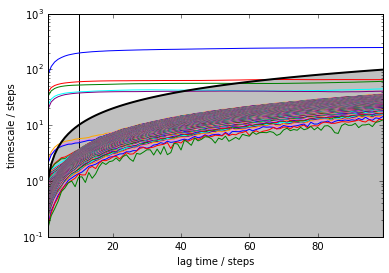

In [5]:
pyemma.plots.plot_implied_timescales(its)
plt.vlines(10,1e-1,1e3)

In [6]:
# estimate MSM
from msmbuilder.msm import MarkovStateModel
msm = MarkovStateModel(lag_time=10)
msm.fit(dtrajs)

MSM contains 1 strongly connected component above weight=0.10. Component 0 selected, with population 100.000000%


MarkovStateModel(ergodic_cutoff='on', lag_time=10, n_timescales=None,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=True)

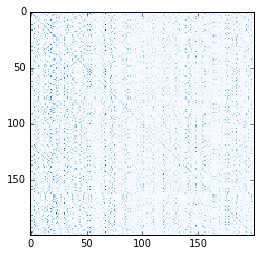

In [7]:
plt.imshow(msm.transmat_,interpolation='none',cmap='Blues')

In [89]:
%%time
# metastability optimization by Monte Carlo Simulated Annealing
from lumping import CoarseGrain
from msmbuilder.lumping import PCCA


n_clusters = range(2,20)

mcsa_repetitions = []
for T in range(10):

    opt_traces = []
    for n in n_clusters:
        initial_guess = PCCA.from_msm(msm,n).microstate_mapping_
        cg = CoarseGrain(n_macrostates=n)
        cg.fit(msm.transmat_,msm.populations_,init_cg_map=initial_guess)
        opt_traces.append((n,cg.optimization_trace))

    mcsa_results = [trace[-1][1] for trace in opt_traces]
    mcsa_repetitions.append(mcsa_results)

Optimization complete: coarse-grained metastability = 0.966
Optimization complete: coarse-grained metastability = 0.908
Optimization complete: coarse-grained metastability = 0.848
Optimization complete: coarse-grained metastability = 0.818
Optimization complete: coarse-grained metastability = 0.820
Optimization complete: coarse-grained metastability = 0.684
Optimization complete: coarse-grained metastability = 0.604
Optimization complete: coarse-grained metastability = 0.549
Optimization complete: coarse-grained metastability = 0.517
Optimization complete: coarse-grained metastability = 0.452
Optimization complete: coarse-grained metastability = 0.419
Optimization complete: coarse-grained metastability = 0.395
Optimization complete: coarse-grained metastability = 0.363
Optimization complete: coarse-grained metastability = 0.344
Optimization complete: coarse-grained metastability = 0.327
Optimization complete: coarse-grained metastability = 0.300
Optimization complete: coarse-grained me

lumping.py:168: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  init_cg_map = npr.randint(0,self.n_macrostates,len(microstate_T))


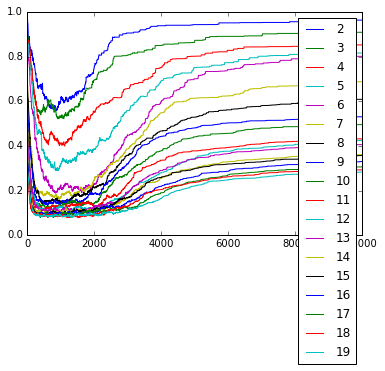

In [90]:
# plot optimization traces, for different choices of n_macrostates
for (n,trace) in opt_traces:
    plt.plot(trace,label=str(n))
plt.ylim(0,1)
plt.legend()

In [81]:
# fit a 2-state model
n=2
cg = CoarseGrain(n_macrostates=n,max_iter=50000)
initial_guess = PCCA.from_msm(msm,n).microstate_mapping_
cg.fit(msm.transmat_,msm.populations_,init_cg_map=initial_guess)

Successfully JIT-compiled inner loop! :)
Optimization complete: coarse-grained metastability = 0.973


In [82]:
mapping,score = cg.solns[-1]

In [83]:
import numpy as np

def plot_contiguous(T,mapping):
    sorted_inds = np.array(sorted(range(len(msm.transmat_)),key=lambda i:mapping[i]))
    plt.imshow(msm.transmat_[sorted_inds][:,sorted_inds],interpolation='none',cmap='Blues')
    plt.colorbar()

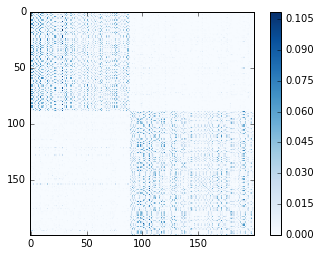

In [84]:
plot_contiguous(msm.transmat_,mapping)

In [14]:
%%time
# hmm let me try something: will an off-the-shelf biclustering algorithm
# work well here?
from sklearn.cluster import SpectralBiclustering
bic = SpectralBiclustering(n_clusters=2,svd_method='arpack',random_state=0)
bic.fit(msm.transmat_)

CPU times: user 120 ms, sys: 2.11 ms, total: 122 ms
Wall time: 121 ms


In [15]:
# huh, that's cool: metastability optimization and spectral biclustering
# arrived at mappings with similar metastability in this case

def relative_metastability(mapping_):
    T = cg.cg_T(msm.transmat_,msm.populations_,mapping_)
    return np.trace(T)/len(T)

print(relative_metastability(bic.column_labels_))
print(relative_metastability(bic.row_labels_))

0.972958438901
0.972958438901


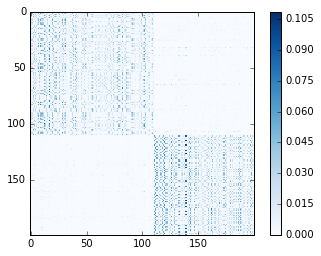

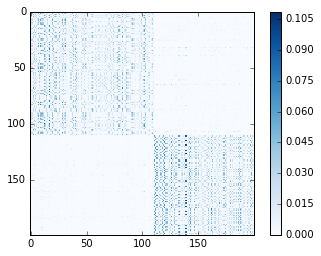

In [16]:
plot_contiguous(msm.transmat_,bic.row_labels_)
plt.figure()
plot_contiguous(msm.transmat_,bic.column_labels_)

In [17]:
%%time
# what about spectral co-clustering?
from sklearn.cluster import SpectralCoclustering
cocluster = SpectralCoclustering(2,svd_method='arpack',random_state=10)
cocluster.fit(msm.transmat_)
print(relative_metastability(cocluster.column_labels_))
print(relative_metastability(cocluster.row_labels_))

0.805518498803
0.824036507681
CPU times: user 11.6 ms, sys: 732 µs, total: 12.3 ms
Wall time: 11.5 ms


In [36]:
%%time
# let's test out spectral co-clustering
repetitions = []
for T in range(10):
    cocluster_scores = []
    for i in n_clusters:
        cocluster = SpectralCoclustering(i,svd_method='arpack')
        cocluster.fit(msm.transmat_)
        cocluster_scores.append(relative_metastability(cocluster.row_labels_))
        #print(cocluster_scores[-1])
    repetitions.append(cocluster_scores)
repetitions = np.array(repetitions)

CPU times: user 4.5 s, sys: 17.5 ms, total: 4.52 s
Wall time: 4.52 s


In [45]:
%%time
# let's test out spectral biclustering
bic_repetitions = []
for T in range(10):
    bic_scores = []
    for i in n_clusters:
        bic = SpectralBiclustering(i,svd_method='arpack')
        bic.fit(msm.transmat_)
        bic_scores.append(relative_metastability(bic.row_labels_))
        #print(cocluster_scores[-1])
    bic_repetitions.append(bic_scores)
bic_repetitions = np.array(bic_repetitions)

CPU times: user 55.9 s, sys: 243 ms, total: 56.2 s
Wall time: 56.4 s


In [19]:
%%time

# let's test out PCCA+
from msmbuilder import lumping
pcca = lumping.PCCAPlus.from_msm(msm,2)

Optimization terminated successfully.
         Current function value: -1.945917
         Iterations: 9
         Function evaluations: 26
CPU times: user 90.8 ms, sys: 4.66 ms, total: 95.4 ms
Wall time: 90.2 ms


In [50]:
%%time
pcca = lumping.PCCA.from_msm(msm,2)

CPU times: user 44.2 ms, sys: 8.77 ms, total: 53 ms
Wall time: 46.1 ms


In [57]:
%%time
# compute PCCA performance over a range of n_macrostates
pcca_repetitions_ = []
for T in range(10):
    pcca_results = []
    for n in n_clusters:
        pcca = lumping.PCCA.from_msm(msm,n)
        pcca_results.append(relative_metastability(pcca.microstate_mapping_))
    pcca_repetitions_.append(pcca_results)

CPU times: user 7.3 s, sys: 618 ms, total: 7.92 s
Wall time: 7.22 s


In [38]:
%%time
# compute PCCA+ performance over a range of n_macrostates
pcca_repetitions = []
for T in range(10):
    pcca_results = []
    for n in n_clusters:
        pcca = lumping.PCCAPlus.from_msm(msm,n)
        pcca_results.append(relative_metastability(pcca.microstate_mapping_))
    pcca_repetitions.append(pcca_results)

Optimization terminated successfully.
         Current function value: -1.945917
         Iterations: 9
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: -2.781424
         Iterations: 9
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: -3.590171
         Iterations: 11
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -4.362167
         Iterations: 8
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: -5.146422
         Iterations: 9
         Function evaluations: 242
Optimization terminated successfully.
         Current function value: -5.182749
         Iterations: 20
         Function evaluations: 318
Optimization terminated successfully.
         Current function value: -5.418015
         Iterations: 8
         Function evaluations: 407
Optimization terminated suc

In [ ]:
# above benchmark took 5min 45s, in case you don't want to scroll down to the bottom of the
# verbose optimization output

# spectral co-clustering only took 5 seconds

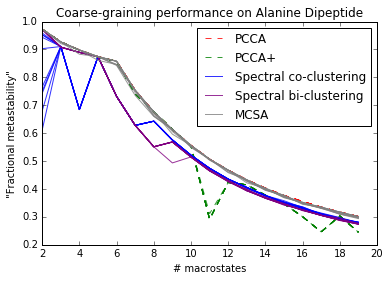

In [91]:
# styles
pcca_color='red'
pcca_plus_color='green'
cocluster_color='blue'
bic_color='purple'
mcsa_color='grey'

alpha=0.8

# PCCA
plt.plot(n_clusters,pcca_repetitions_[0],color=pcca_color,linestyle='--',label='PCCA',alpha=alpha)
for replicate in pcca_repetitions_[1:]:
    plt.plot(n_clusters,replicate,color=pcca_color,linestyle='--',alpha=alpha)
    
# PCCA+ 
plt.plot(n_clusters,pcca_repetitions[0],color=pcca_plus_color,linestyle='--',label='PCCA+',alpha=alpha)
for replicate in pcca_repetitions[1:]:
    plt.plot(n_clusters,replicate,color=pcca_plus_color,linestyle='--',alpha=alpha)

# spectral co-clustering
plt.plot(n_clusters,repetitions[0],color=cocluster_color,label='Spectral co-clustering',alpha=alpha)
for replicate in repetitions[1:]:
    plt.plot(n_clusters,replicate,color=cocluster_color,alpha=alpha)
    
# spectral bi-clustering
plt.plot(n_clusters,bic_repetitions[0],color=bic_color,label='Spectral bi-clustering',alpha=alpha)
for replicate in bic_repetitions[1:]:
    plt.plot(n_clusters,replicate,color=bic_color,alpha=alpha)
    
# metastability optimization  
plt.plot(n_clusters,mcsa_repetitions[0],color=mcsa_color,label='MCSA',alpha=alpha)
for replicate in mcsa_repetitions[1:]:
    plt.plot(n_clusters,replicate,color=mcsa_color,alpha=alpha)


#plt.ylim(0,1)
plt.ylabel('"Fractional metastability"')
plt.xlabel('# macrostates')
plt.title('Coarse-graining performance on Alanine Dipeptide')
plt.legend()

# to-do: replace replicate curves with shaded mean +/- error regions

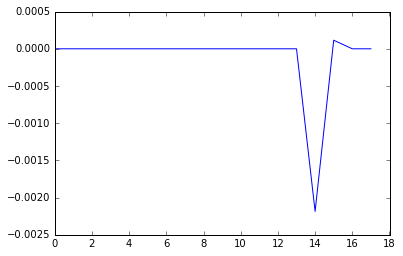

In [99]:
# versus PCCA
plt.plot(np.array(mcsa_repetitions).max(0)-np.array(pcca_repetitions_).max(0))

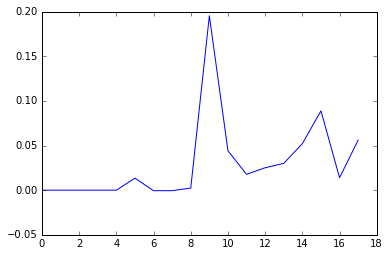

In [100]:
# versus PCCA+
plt.plot(np.array(mcsa_repetitions).max(0)-np.array(pcca_repetitions).max(0))

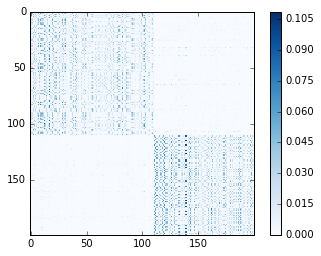

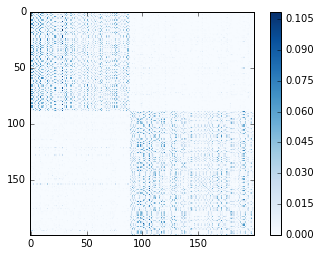

In [53]:
cocluster = SpectralBiclustering(2,svd_method='arpack')
cocluster.fit(msm.transmat_)
plot_contiguous(msm.transmat_,cocluster.row_labels_)
plt.figure()
plot_contiguous(msm.transmat_,cocluster.column_labels_)